In [1]:
# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer

#Librairies
import time
import torch
import random

#Raccourcis utilisé
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.utils.data as data_utils
import pandas as pd

# Import Keras
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adamax, Nadam
from sklearn.model_selection import train_test_split
from math import exp

Using TensorFlow backend.


In [2]:
def to_array(X_AT_train, y_AT_train):
    training_in = np.empty([len(X_AT_train), 4872], dtype = float) #features inputs
    training_out = np.empty([len(y_AT_train), 1], dtype = float) #labels outputs
    for i in range(len(X_AT_train)): #1280
        training_out[i] = y_AT_train[i]
        for j in range(len(list_label)): #10
            training_in[i][j] = X_AT_train[list_label[j]][i]
    return(training_in, training_out)

In [3]:
def to_class(y_):
    res = np.zeros((len(y_), 11), dtype='q')
    for i in range(len(y_)):
        res[i][int(y_[i])] = 1
    return res

In [4]:
# Normalisation
sc = StandardScaler()

In [5]:
dfX = pd.read_csv('Molecular Dataset Dream 1.csv',sep=';')
dfY = pd.read_csv('Senteur Dataset Dream 1.csv',sep=';')

In [6]:
df = dfX.merge(dfY)

In [7]:
list_label = ['INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

dfY_ = df[['INTENSITY/STRENGTH']]
df = df.drop(list_label,axis=1)
df = df.drop('Unnamed: 0',axis=1)
df = df.drop('CID',axis=1)
colonne = list(df)

## Keras

## Pytorch

In [8]:
Epoch = 30
rand = 15
Nb_param = [30,300,1000,2000,3083]
ACC_30,ACC_300,ACC_1000,ACC_2000,ACC_3083 = [0]*Epoch,[0]*Epoch,[0]*Epoch,[0]*Epoch,[0]*Epoch
ACC = {30: ACC_30,300: ACC_300,1000: ACC_1000,2000: ACC_2000,3083: ACC_3083}
dfY = dfY_
dataY = np.longlong(dfY.values)
dataY = to_class(dataY)
for j in Nb_param:
    print("trainning for",j,"param :")
    Start_time = time.time()
    for z in range(rand):
        #pour faire des moyennes
        L = random.sample(colonne, k=j)
        dfX = pd.DataFrame()
        for i in L:
            dfX['{}'.format(i)] = df['{}'.format(i)]
        
        dataX = np.float32(dfX.values)
        dataX = sc.fit_transform(dataX)
        DATA_Train, DATA_Test, TARGET_Train, TARGET_Test = train_test_split(dataX, dataY ,test_size=0.1)

        Batch = 300
        X_train_tensor = torch.from_numpy(DATA_Train)
        Y_train_tensor = torch.from_numpy(TARGET_Train)
        X_test_tensor = torch.from_numpy(DATA_Test)
        Y_test_tensor = torch.from_numpy(TARGET_Test)

        train = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
        train_loader = data_utils.DataLoader(train, batch_size=Batch, shuffle=True)
        test = data_utils.TensorDataset(X_test_tensor, Y_test_tensor)
        test_loader = data_utils.DataLoader(test, batch_size=Batch, shuffle=True)
######################################################################################
        a,b,c,d = j , 2400 , 1200 , 600
        class MyNetwork(nn.Module):
            def __init__(self):
                super(MyNetwork, self).__init__()
                ## Activation layer
                self.relu = nn.ReLU()
                self.fc1 = nn.Linear(in_features = a, out_features = b)
                self.fc2 = nn.Linear(b, c)  
                self.fc3 = nn.Linear(c, d)
                self.output = nn.Linear( d , 11)
                self.softmax = nn.LogSoftmax(dim=1)
            def forward(self, x):
            ## First full connection
                x = self.fc1(x)
                x = self.relu(x)
            ## Second full connection
                x = self.fc2(x)
                x = self.relu(x)
            ## Third full connection
                x = self.fc3(x)
                x = self.relu(x)
            ## Output layer
                x = self.output(x)
                y = self.softmax(x)
                return y
############################################################################
        net = MyNetwork()
        net = net.cuda()

        LEARNING_RATE = 0.003
        MOMENTUM = 0.9

        criterion = nn.NLLLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

        N_EPOCHS = Epoch

        epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
        start_time = time.time()
        for e in range(N_EPOCHS):
            running_loss = 0
            running_accuracy = 0
            running_acc=0
            start_epoch_time=time.time()
            net.train()
            for i, batch in enumerate(train_loader):
                x = batch[0]
                labels = batch[1]
                x = x.cuda()
                labels = labels.cuda()
                output = net(x)
                y = output
                loss = criterion(y, torch.max(labels, 1)[1])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()  
                with torch.no_grad():
                    running_loss += loss.item()            
                    running_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
            epoch_loss.append(running_loss/len(train))
            epoch_acc.append(running_accuracy/len(train))
            net.eval()
            running_val_loss = 0
            running_val_accuracy = 0

            for i, batch in enumerate(test_loader):
                with torch.no_grad():
                    x = batch[0]
                    labels = batch[1]
                    x = x.cuda()
                    labels = labels.cuda()
                    output = net(x)
                    y = output
                    loss = criterion(y, torch.max(labels, 1)[1])
                    running_val_loss += loss.item()
                    running_val_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()

            epoch_val_loss.append(running_val_loss/len(test))
            epoch_val_acc.append(running_val_accuracy/len(test))
        inter = time.time() - start_time
        print("train",z+1," sur", Epoch,"epoch :",running_val_accuracy/len(test))
        print ('Temps en secondes:', inter )
        for u in range(Epoch):
            ACC[j][u] += epoch_acc[u] 
    for u in range(Epoch):
        ACC[j][u] = ACC[j][u]/rand
    interval = time.time() - Start_time  
    print ('Temps total en secondes pour',j,'parametres:', interval)

trainning for 30 param :
train 1  sur 30 epoch : 0.17041581458759372
Temps en secondes: 27.609731197357178
train 2  sur 30 epoch : 0.17893660531697342
Temps en secondes: 25.492364168167114
train 3  sur 30 epoch : 0.18200408997955012
Temps en secondes: 25.678426504135132
train 4  sur 30 epoch : 0.18677573278800272
Temps en secondes: 26.553322792053223
train 5  sur 30 epoch : 0.18166325835037492
Temps en secondes: 25.626859188079834
train 6  sur 30 epoch : 0.17927743694614862
Temps en secondes: 25.740175485610962
train 7  sur 30 epoch : 0.17246080436264485
Temps en secondes: 26.446784734725952
train 8  sur 30 epoch : 0.18200408997955012
Temps en secondes: 26.364956855773926
train 9  sur 30 epoch : 0.17211997273346966
Temps en secondes: 27.854477882385254
train 10  sur 30 epoch : 0.1796182685753238
Temps en secondes: 26.15336012840271
train 11  sur 30 epoch : 0.18473074301295161
Temps en secondes: 26.211045026779175
train 12  sur 30 epoch : 0.17825494205862305
Temps en secondes: 26.177359

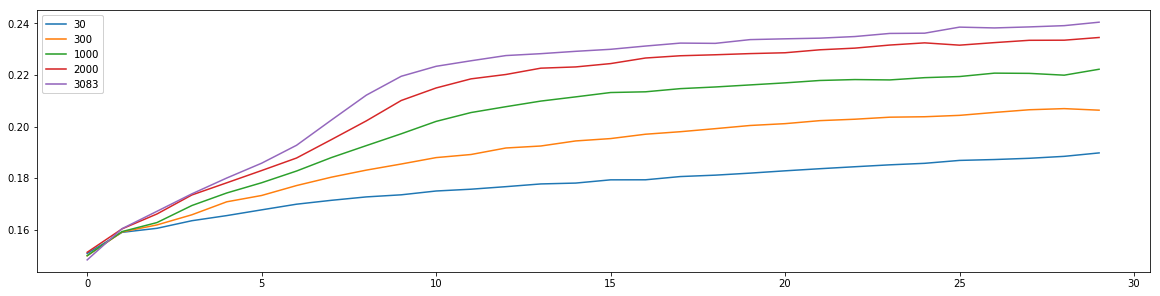

In [9]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)
line1, = plt.plot(ACC_30, label="30")
line2, = plt.plot(ACC_300, label="300")
line3, = plt.plot(ACC_1000, label="1000")
line4, = plt.plot(ACC_2000, label="2000")
line5, = plt.plot(ACC_3083, label="3083")
first_legend = plt.legend(handles=[line1,line2,line3,line4,line5], loc='upper left')
ax = plt.gca().add_artist(first_legend)

plt.show()